## Libraries

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [58]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
#from torch.utils.data.dataset import Subset

In [59]:
import pandas as pd

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
from tqdm.notebook import tqdm

In [62]:
import cv2
from google.colab.patches import cv2_imshow

In [63]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset

### データの読み込み

In [64]:
def makeDataList(csv_path):
  datalist = pd.read_csv(csv_path)
  return datalist

In [65]:
datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/train.csv")

In [66]:
datalist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
train_datalist, test_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)

In [68]:
print(train_datalist.shape)
print(test_datalist.shape)
print(train_datalist.values)
train_datalist.head()

(37800, 785)
(4200, 785)
[[5 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [9 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10037,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13376,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13038,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3805,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3464,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Datasetの作成

In [69]:
#DataFrameからndarrayに変換.　Datasetを継承し，DataLoaderの第一引数にできる．
class DatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.drop(["label"], axis=1).values.astype(np.float32).reshape(-1, 28, 28)
    self.label_datalist = datalist["label"].values.astype(np.int64)
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    labels = self.label_datalist[index]
    return inputs, labels

In [70]:
class ImageTransform():
  def __init__(self, mean=0, std=255):
    self.data_transform = transforms.Compose([

        transforms.ToTensor(),
        transforms.Resize(56),
        transforms.Normalize(mean, std),
    ])
  def __call__(self, img):
    return self.data_transform(img)

In [71]:
#デフォルトでは引数がindexではなくidxのため定義しなおしてみる．
class Subset(DatasetMaker):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

In [72]:
trainval_dataset = DatasetMaker(train_datalist, transform=ImageTransform(mean=0, std=255))
n_samples = len(trainval_dataset)
train_size = int(n_samples * 0.8)

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, n_samples))

train_dataset = Subset(trainval_dataset, train_indices)
val_dataset = Subset(trainval_dataset, val_indices)

test_dataset = DatasetMaker(test_datalist, transform=ImageTransform(mean=0, std=255))
print(train_dataset.__len__())
print(val_dataset.__len__())
#print(train_dataset.__getitem__(index=0)[0])
#print(train_dataset.__getitem__(index=0)[1])

30240
7560


torch.Size([1, 56, 56])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


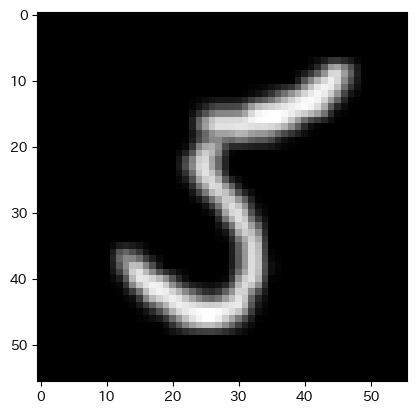

In [73]:
tmp = train_dataset.__getitem__(index=0)[0]
print(tmp.shape)
tmp = torch.squeeze(tmp)
plt.imshow(tmp.detach().numpy().copy(), cmap="gray")
plt.show()

## DataLoader

In [74]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader, "test":test_dataloader}
for inputs_tmp, labels_tmp in test_dataloader:
  break
#batch_itr = iter(dataloader)
#inputs, labels = next(batch_itr)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

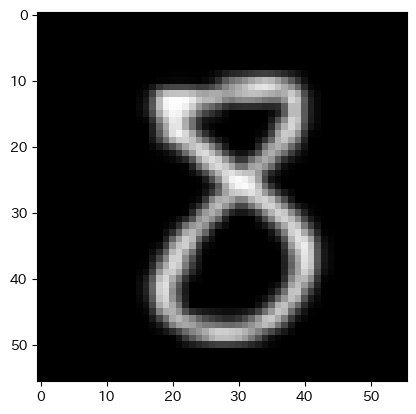

tensor([8, 3, 1,  ..., 8, 2, 1])
torch.Size([4200])


In [75]:
print(inputs_tmp)
print(inputs_tmp.size())
plt.imshow(inputs_tmp[0].detach().numpy().copy().reshape(56, 56), cmap="gray")
plt.show()
print(labels_tmp)
print(labels_tmp.size())

## Network

In [76]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [78]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [79]:
summary(net, (64, 1, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 1000]                --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 56, 56]          640
│    └─ReLU: 2-2                         [64, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [64, 64, 56, 56]          36,928
│    └─ReLU: 2-4                         [64, 64, 56, 56]          --
│    └─MaxPool2d: 2-5                    [64, 64, 28, 28]          --
│    └─Conv2d: 2-6                       [64, 128, 28, 28]         73,856
│    └─ReLU: 2-7                         [64, 128, 28, 28]         --
│    └─Conv2d: 2-8                       [64, 128, 28, 28]         147,584
│    └─ReLU: 2-9                         [64, 128, 28, 28]         --
│    └─MaxPool2d: 2-10                   [64, 128, 14, 14]         --
│    └─Conv2d: 2-11                      [64, 256, 14, 14]         295,

## Loss Function

In [80]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [81]:
# 学習率に傾斜をかける（最後に近づくほど高い学習率に）．
# パラメータを，featuresモジュールのパラメータ，最後の全結合層以外の全結合層のパラメータ，最後の全結合層のパラメータに分けて管理．
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
  if update_param_names_1[0] in name: # featuresが含まれるパラメータ名の場合
    param.requires_grad = True
    params_to_update_1.append(param)
    print("params_to_update_1に格納：", name)
  elif name in update_param_names_2: # パラメータ名がリストに含まれる場合
    param.requires_grad = True
    params_to_update_2.append(param)
    print("params_to_update_2に格納：", name)
  elif name in update_param_names_3: # パラメータ名がリストに含まれる場合
    param.requires_grad = True
    params_to_update_3.append(param)
    print("params_to_update_3に格納：", name)
  else: # ここに属するパラメータはないはず．
    param.requires_grad = False
    print("勾配計算なし．学習しない：", name)

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [82]:
optimizer = optim.SGD([
  {"params": params_to_update_1, "lr": 1e-4},
  {"params": params_to_update_2, "lr": 3e-4},
  {"params": params_to_update_3, "lr": 6e-4}
], momentum=0.9)

## Train

In [83]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, device):
  net.to(device)

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("--------------")

    for phase in ["train", "val"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, dim=1)

          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds.data == labels.data)
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

In [84]:
num_epochs = 16

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.8571 Acc: 0.5451


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.3168 Acc: 0.8931
Epoch 2/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.2669 Acc: 0.9206


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.1348 Acc: 0.9425
Epoch 3/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.1534 Acc: 0.9537


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.1002 Acc: 0.9524
Epoch 4/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.1171 Acc: 0.9639


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0827 Acc: 0.9571
Epoch 5/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0968 Acc: 0.9702


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0720 Acc: 0.9602
Epoch 6/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0835 Acc: 0.9744


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0670 Acc: 0.9616
Epoch 7/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0733 Acc: 0.9769


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0671 Acc: 0.9631
Epoch 8/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0661 Acc: 0.9793


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0593 Acc: 0.9638
Epoch 9/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0600 Acc: 0.9801


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0547 Acc: 0.9664
Epoch 10/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0549 Acc: 0.9817


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0538 Acc: 0.9661
Epoch 11/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0527 Acc: 0.9829


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0538 Acc: 0.9671
Epoch 12/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0473 Acc: 0.9843


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0496 Acc: 0.9673
Epoch 13/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0431 Acc: 0.9854


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0483 Acc: 0.9667
Epoch 14/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0403 Acc: 0.9866


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0459 Acc: 0.9688
Epoch 15/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0398 Acc: 0.9866


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0483 Acc: 0.9680
Epoch 16/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0368 Acc: 0.9881


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0453 Acc: 0.9687


In [85]:

save_weights_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer03/model.pth'
torch.save(net.state_dict(), save_weights_path)

## 評価

In [86]:
def Evaluator():
  for inputs, labels in dataloaders_dict["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)

    corrects = torch.sum(preds == labels)
    print("acc:{}".format(corrects/len(dataloaders_dict["test"].dataset)))
    print("loss:{}".format(loss))

In [87]:
Evaluator()

acc:0.9873809218406677
loss:0.040859319269657135


## 結果

In [88]:
class AnsDatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.values.astype(np.float32).reshape(-1, 28, 28)
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    return inputs

In [89]:
ans_datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/test.csv")
ans_datalist.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
batch_size = 128
ans_dataset = AnsDatasetMaker(ans_datalist, transform=ImageTransform(mean=0, std=255))
ans_dataloader = DataLoader(ans_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [91]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer03/model.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [92]:
def Prediction(net, dataloaders_dict, device):
  net.to(device)
  net.eval()
  preds = torch.tensor([]).to(device)

  for inputs in tqdm(ans_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
      outputs = net(inputs)
      _, batch_preds = torch.max(outputs, dim=1)
      preds = torch.cat((preds, batch_preds), dim=0)

  return preds

In [93]:
preds = Prediction(net, ans_dataloader, device)

  0%|          | 0/219 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [94]:
print(preds)
print(preds.shape)

tensor([2., 0., 9.,  ..., 3., 9., 2.], device='cuda:0')
torch.Size([28000])


In [95]:
submission = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/sample_submission.csv")
submission = submission.drop("Label", axis = 1)
print(submission.shape)
submission.head()

(28000, 1)


,ImageId
0,1
1,2
2,3
3,4
4,5


In [96]:
preds_df = pd.DataFrame({"Label": preds.to("cpu").detach().numpy().copy()})
preds_df = preds_df.astype('int')
submission = pd.concat([submission, preds_df], axis=1)

In [97]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [98]:
print(submission.dtypes)
submission = submission.astype('int64')
print(submission.dtypes)

ImageId    int64
Label      int64
dtype: object
ImageId    int64
Label      int64
dtype: object


In [99]:
save_csv_path = "/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer03/submission.csv"
submission.to_csv(save_csv_path, index=False)